<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1037501 entries, 0 to 1037500
Data columns (total 99 columns):
 #   Column                                    Non-Null Count    Dtype  
---  ------                                    --------------    -----  
 0   activity_year                             1037501 non-null  int64  
 1   lei                                       1037501 non-null  object 
 2   derived_msa-md                            1037501 non-null  int64  
 3   state_code                                1037501 non-null  object 
 4   county_code                               1024482 non-null  float64
 5   census_tract                              1011063 non-null  float64
 6   conforming_loan_limit                     1035129 non-null  object 
 7   derived_loan_product_type                 1037501 non-null  object 
 8   derived_dwelling_category                 1037501 non-null  object 
 9   derived_ethnicity                         1037501 non-null  object 
 10  derive

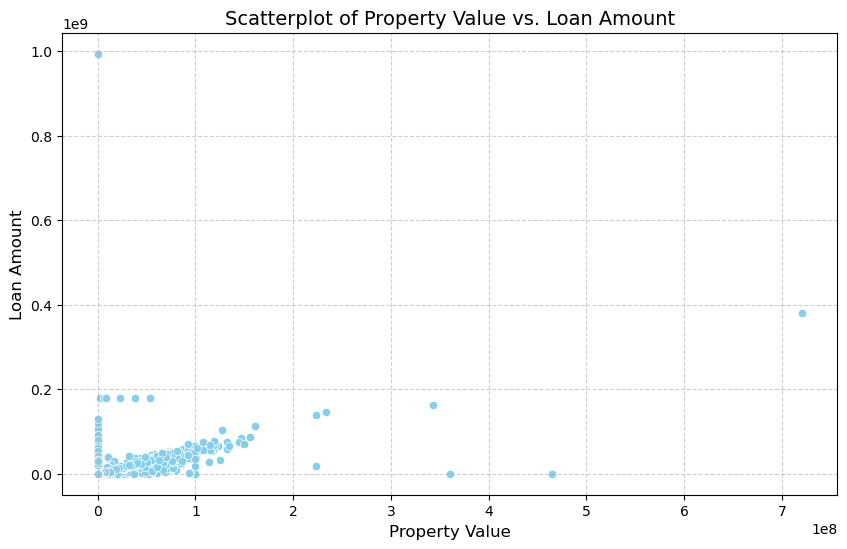

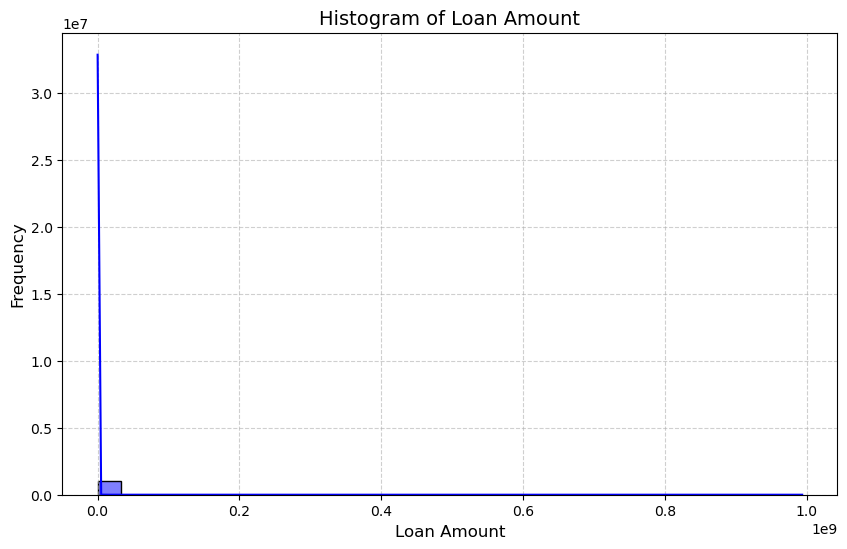

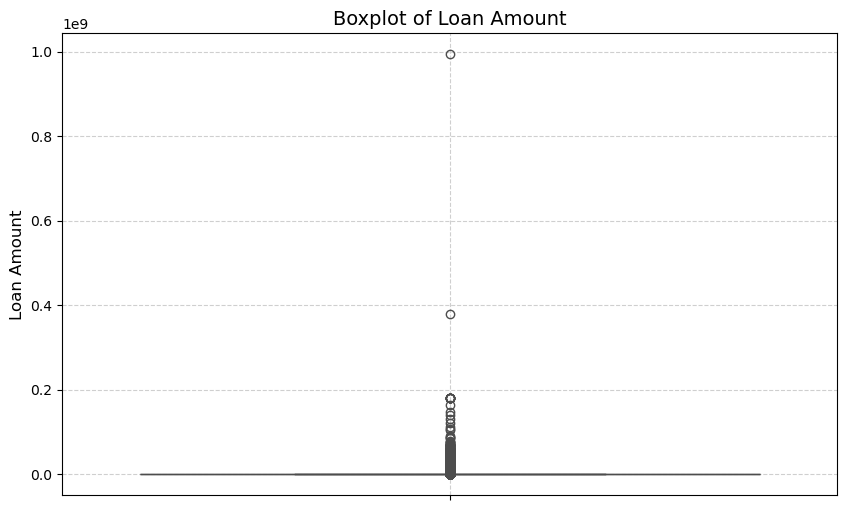

The county code with the most applications is 48201.0 with 137218 applications.


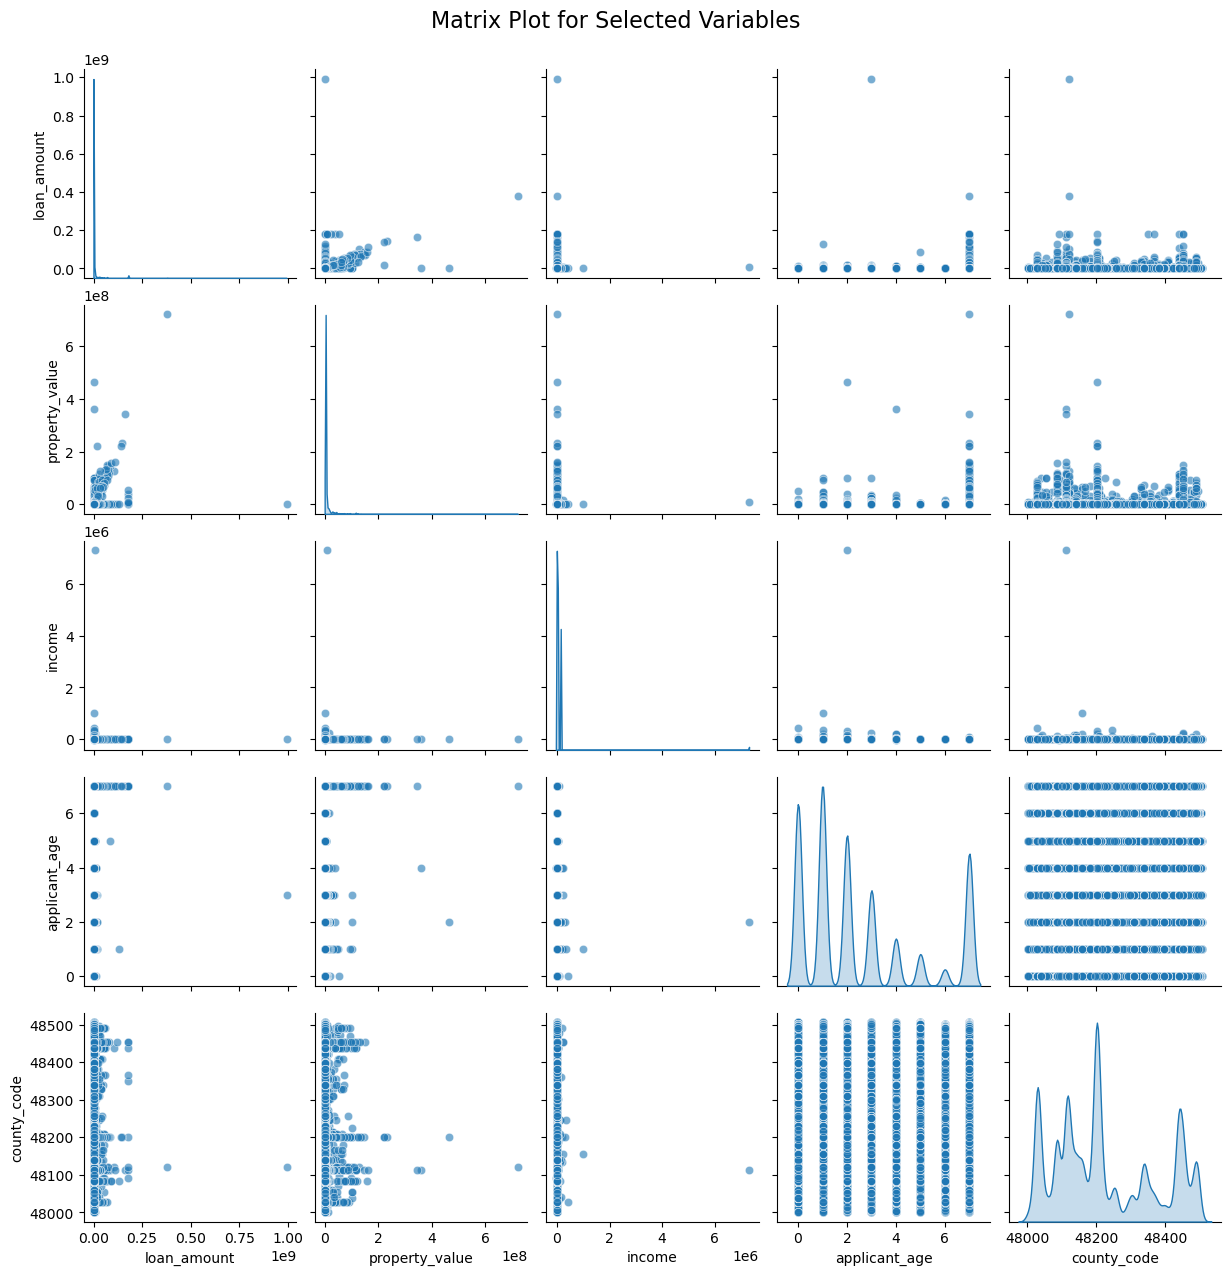

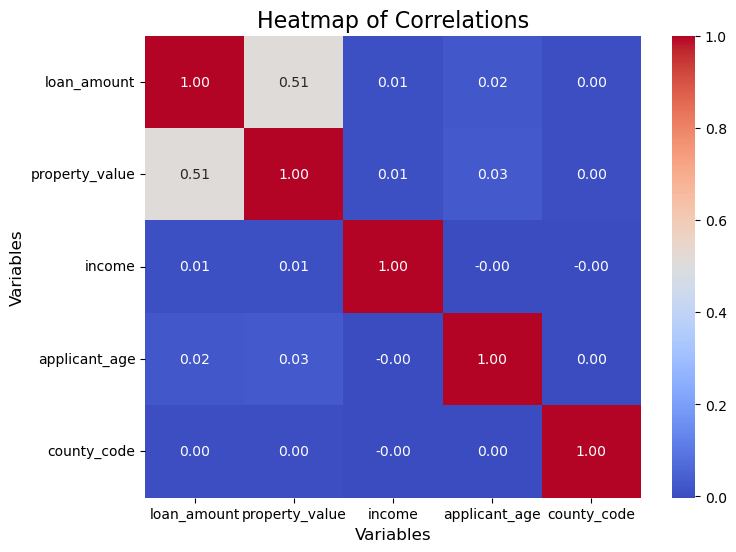

X: [[ 0.53237161  0.01163104 -0.16305789 ...  0.01196712  0.43278045  3.62385573]
 [ 0.3828745  -0.87647201  0.05986574 ...  0.01196712  0.43278045 -0.28821253]
 [-0.31024847 -0.48175954 -0.1931827  ...  0.01196712  0.43278045 -0.28821253]
 ...
 [ 1.76912044 -0.38308143 -0.07268344 ...  0.01196712  0.43278045 -0.28821253]
 [ 0.57314355 -0.1857252  -0.144983   ...  0.01196712  0.43278045 -0.28821253]
 [-0.16075136 -1.27118447 -0.03653366 ...  0.01196712  0.43278045 -0.28821253]]
Y: [-0.13169885  0.15221102 -0.14521836 ... -0.00326343 -0.08438053  0.03729512]
Shape of X_train: (813484, 8)
Shape of Y_train: (813484,)
Shape of X_test: (203372, 8)
Shape of Y_test: (203372,)
R-squared:  0.744
RMSE: 0.426
Intercept: 0.0003
Coefficients: [0.0013, -0.0128, 0.4692, 0.008, 0.0027, 0.0007, 0.0297, 0.026]


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


property_value: 0.727204625658334
income: 0.09132386222484118
loan_term: 0.07215257456993888
occupancy_type: 0.03863712230004514
interest_rate: 0.03503204861785034
applicant_age: 0.03037499083794633
county_code: 0.004099243531931191
debt_to_income_ratio: 0.0011755322591128546
R-squared:  0.333
RMSE: 0.687


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


R-squared:  0.508
RMSE: 0.59


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


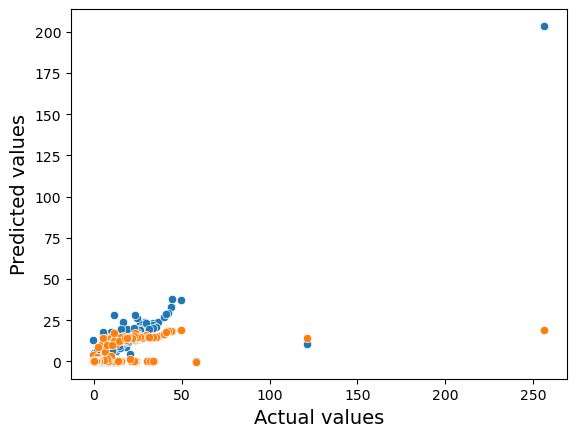

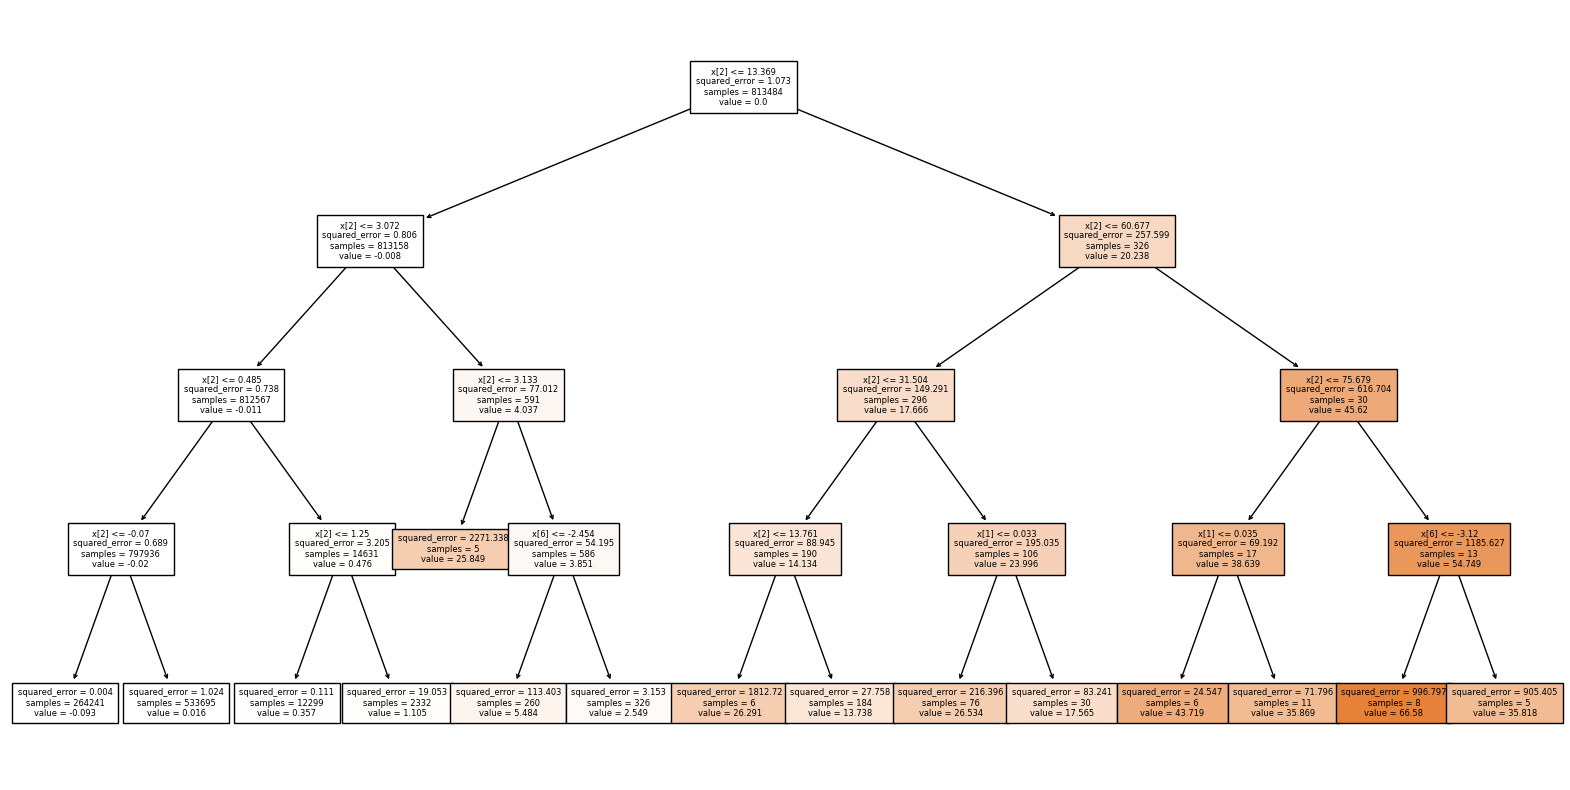

In [1]:
"""
Texas Mortgage Data Analysis Pipeline
======================================
This script performs comprehensive data cleaning, exploratory data analysis (EDA),
and machine learning model training for Texas mortgage loan data.

"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree

# ============================================================================
# PART 1: DATA LOADING AND INITIAL INSPECTION
# ============================================================================
    
# Load dataset with low_memory=False to prevent dtype warnings
file_path = "/Users/ht/Desktop/Fall_2024/ADTA_5340/group_project/content/state_TX.csv" 
data = pd.read_csv(file_path, low_memory=False)
    
data.info()

# ============================================================================
# STEP 3: Identify Numerical and Categorical Columns
# ============================================================================
num_cols = data.select_dtypes(include=["float64", "int64"]).columns.tolist()
cat_cols = data.select_dtypes(include=["object"]).columns.tolist()

# ============================================================================
# STEP 4: Handle Missing Values in Numerical Columns
# ============================================================================
for column in num_cols:
    data[column] = pd.to_numeric(data[column], errors='coerce')  # Ensure numeric
    data[column] = data[column].fillna(data[column].median())  # Replace NaN with median

# ============================================================================
# STEP 5: Handle Missing Values in Categorical Columns
# ============================================================================
for column in cat_cols:
    if not data[column].mode().empty:
        data[column] = data[column].fillna(data[column].mode()[0])  # Replace with mode

# ============================================================================
# STEP 6: Handle Specific Invalid Values
# ============================================================================
invalid_entries = ['Exempt', 'NA', 'NaN', '8888', 8888, '(Blanks)']
data.replace(invalid_entries, np.nan, inplace=True)

# ============================================================================
# STEP 7: Drop Rows with Missing Data in Critical Columns
# ============================================================================
critical_columns = ['county_code', 'loan_term']
data.dropna(subset=critical_columns, inplace=True)

# ============================================================================
# STEP 8: Encode Categorical Features
# ============================================================================
label_encoder = LabelEncoder()

# Encode 'applicant_age' if it's categorical
if data['applicant_age'].dtype == 'object':
    data['applicant_age'] = label_encoder.fit_transform(data['applicant_age'])

# Encode 'occupancy_type'
if 'occupancy_type' in data.columns:
    data['occupancy_type'] = label_encoder.fit_transform(data['occupancy_type'])

# ============================================================================
# STEP 9: Handle Missing Data in Selected Numeric Features
# ============================================================================
numeric_features = ['interest_rate', 'property_value', 'income', 'debt_to_income_ratio']
for feature in numeric_features:
    data[feature] = pd.to_numeric(data[feature], errors='coerce')
    data[feature] = data[feature].fillna(data[feature].median())

# ============================================================================
# STEP 10: Select Relevant Features for Machine Learning
# ============================================================================
selected_features = [
    'county_code', 'interest_rate', 'property_value', 'applicant_age',
    'income', 'debt_to_income_ratio', 'loan_term', 'occupancy_type', 'loan_amount'
]
cleaned_data = data[selected_features].copy()

# ============================================================================
# STEP 11: Final Check and Save Cleaned Data
# ============================================================================
print("Missing values after cleaning:")
print(cleaned_data.isnull().sum())

# Save cleaned data for further analysis or modeling
cleaned_data.to_csv("cleaned_mortgage_dataset.csv", index=False)

# Display a preview of the cleaned dataset
print("Preview of Cleaned Data:")
print(cleaned_data.head())

# ============================================================================
# VISUALIZATION 1: Scatterplot between 'property_value' and 'loan_amount'
# ============================================================================
plt.figure(figsize=(10, 6))
sns.scatterplot(data=cleaned_data, x='property_value', y='loan_amount', color='skyblue')
plt.title('Scatterplot of Property Value vs. Loan Amount', fontsize=14)
plt.xlabel('Property Value', fontsize=12)
plt.ylabel('Loan Amount', fontsize=12)
plt.grid(visible=True, linestyle='--', alpha=0.6)
plt.show()

# ============================================================================
# VISUALIZATION 2: Histogram for 'loan_amount'
# ============================================================================
plt.figure(figsize=(10, 6))
sns.histplot(data=cleaned_data, x='loan_amount', kde=True, bins=30, color='blue')
plt.title('Histogram of Loan Amount', fontsize=14)
plt.xlabel('Loan Amount', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(visible=True, linestyle='--', alpha=0.6)
plt.show()

# ============================================================================
# VISUALIZATION 3: Boxplot for 'loan_amount'
# ============================================================================
plt.figure(figsize=(10, 6))
sns.boxplot(data=cleaned_data, y='loan_amount', color='orange')
plt.title('Boxplot of Loan Amount', fontsize=14)
plt.ylabel('Loan Amount', fontsize=12)
plt.grid(visible=True, linestyle='--', alpha=0.6)
plt.show()

# ============================================================================
# ANALYSIS: Find the county with the most applications
# ============================================================================
county_count = cleaned_data.groupby('county_code').size()
most_common_county = county_count.idxmax()
max_count = county_count.max()
print(f"The county code with the most applications is {most_common_county} with {max_count} applications.")

# ============================================================================
# VISUALIZATION 4: Matrix Plot for Selected Variables (Pairplot)
# ============================================================================
# Subset the data for the selected columns
subset_data = cleaned_data[['loan_amount', 'property_value', 'income', 'applicant_age', 'county_code']].copy()

# Convert county_code to numeric if it's not already
subset_data['county_code'] = pd.to_numeric(subset_data['county_code'], errors='coerce')

# Create a pairplot
sns.pairplot(subset_data, diag_kind='kde', plot_kws={'alpha': 0.6})

# Add a title to the plot
plt.suptitle('Matrix Plot for Selected Variables', y=1.02, fontsize=16)

# Display the plot
plt.show()

# ============================================================================
# VISUALIZATION 5: Heatmap of Correlations
# ============================================================================
# Calculate the correlation matrix
correlation_matrix = subset_data.corr()

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)

# Add labels and title
plt.title('Heatmap of Correlations', fontsize=16)
plt.xlabel('Variables', fontsize=12)
plt.ylabel('Variables', fontsize=12)

# Display the heatmap
plt.show()

# ============================================================================
# FEATURE ENGINEERING: Convert Income to Actual Dollars
# ============================================================================
# 'Income' is in thousands of dollars
cleaned_data['income'] = cleaned_data['income'] * 1000

# ============================================================================
# STANDARDIZATION: Standardize All Columns
# ============================================================================
scaler = StandardScaler()
cleaned_data[['county_code','interest_rate', 'property_value',
              'applicant_age','income','debt_to_income_ratio',
              'loan_term','occupancy_type','loan_amount']] = scaler.fit_transform(
    cleaned_data[['county_code','interest_rate', 'property_value','applicant_age',
                  'income','debt_to_income_ratio','loan_term','occupancy_type','loan_amount']]
)

cleaned_data

# ============================================================================
# PREPARE DATA FOR MODELING
# ============================================================================
# Store the dataframe values into a NumPy array
array = cleaned_data.values

# Separate the array into input and output components
# For X (input) --> All the rows and columns, but not include target column
X = array[:,0:-1]
# For Y (output) --> All the rows in the last column (loan_amount)
Y = array[:,-1]

print("X:", X)
print("Y:", Y)

# ============================================================================
# TRAIN-TEST SPLIT: Split the dataset (80% training, 20% testing)
# ============================================================================
test_size = 0.2
seed = 42
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=seed)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of Y_train: {Y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of Y_test: {Y_test.shape}")

# ============================================================================
# MODEL 1: LINEAR REGRESSION
# ============================================================================
# Create the Linear Regression model and fit the model
lin_model = LinearRegression()
lin_model.fit(X_train, Y_train)

# Make predictions using the test dataset
Y_predict_lin = lin_model.predict(X_test)
Y_predict_lin

# Example: Assume we have new input data
new_data = np.array([[48121, 6, 400000, 35, 60000, 40, 120, 1]])
predicted_value = lin_model.predict(new_data)
predicted_value

# Compare testing predictions to actual values
p = sns.scatterplot(x=Y_test, y=Y_predict_lin)
p.set_xlabel("Actual values", fontsize=14)
p.set_ylabel("Predicted values", fontsize=14)

# Evaluate the model - R-squared
R_squared = lin_model.score(X_test, Y_test)
R_squared_rounded_lin = round(R_squared, 3)
print("R-squared: ", R_squared_rounded_lin)

# Display RMSE
rmse = mean_squared_error(Y_test, Y_predict_lin, squared=False)
rmse_rounded_lin = round(rmse, 3)
print('RMSE:', rmse_rounded_lin)

# Print intercept and coefficients
intercept_rounded = round(lin_model.intercept_, 4)
coefficients_rounded = [round(coef, 4) for coef in lin_model.coef_]
print("Intercept:", intercept_rounded)
print("Coefficients:", coefficients_rounded)

# ============================================================================
# MODEL 2: RANDOM FOREST REGRESSOR
# ============================================================================
# Define a Regression Random Forest model and fit the model
rf_model = RandomForestRegressor(max_depth=3, max_features='sqrt', random_state=42)
rf_model.fit(X_train, Y_train)

# Predict loan_amount on the testing data
Y_predict_rf = rf_model.predict(X_test)
Y_predict_rf

# Create a DataFrame include features and corresponding feature importance values
feature_names = ['county_code', 'interest_rate', 'property_value',
                 'applicant_age', 'income', 'debt_to_income_ratio',
                 'loan_term', 'occupancy_type']
feature_importances = rf_model.feature_importances_

# Use np.argsort to get the indices sorted by importance
sorted_indices = np.argsort(feature_importances)[::-1]

# Sort feature names and feature importances by sorted index
sorted_features = np.array(feature_names)[sorted_indices]
sorted_importances = feature_importances[sorted_indices]

for feature, importance in zip(sorted_features, sorted_importances):
    print(f"{feature}: {importance}")

# Compare testing predictions to actual values
p = sns.scatterplot(x=Y_test, y=Y_predict_rf)
p.set_xlabel("Actual values", fontsize=14)
p.set_ylabel("Predicted values", fontsize=14)

# Evaluate the model - R-squared
R_squared = rf_model.score(X_test, Y_test)
R_squared_rounded_rf = round(R_squared, 3)
print("R-squared: ", R_squared_rounded_rf)

# Print root mean squared error (RMSE)
rmse = mean_squared_error(Y_test, Y_predict_rf, squared=False)
rmse_rounded_rf = round(rmse, 3)
print('RMSE:', rmse_rounded_rf)

# ============================================================================
# MODEL 3: DECISION TREE REGRESSOR
# ============================================================================
# Define the Decision Tree Model and fit the model
regtree_model = DecisionTreeRegressor(max_depth=4, min_samples_leaf=5, random_state=42)
regtree_model.fit(X_train, Y_train)

# Predict loan_amount on the testing data
Y_predict_regtree = regtree_model.predict(X_test)
Y_predict_regtree

# Evaluate the model - R-squared
R_squared = regtree_model.score(X_test, Y_test)
R_squared_rounded_regtree = round(R_squared, 3)
print("R-squared: ", R_squared_rounded_regtree)

# Print root mean squared error (RMSE)
rmse = mean_squared_error(Y_test, Y_predict_regtree, squared=False)
rmse_rounded_regtree = round(rmse, 3)
print('RMSE:', rmse_rounded_regtree)

# Using tree.plot_tree() makes a cleaner figure
# Resize the plotting window
plt.figure(figsize=(20, 10))
plot_tree(regtree_model, filled=True, feature_names=None, fontsize=6)
plt.show()

